In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import seaborn as sns
# Warnings configuration
# ==============================================================================
from darts.dataprocessing.transformers import Scaler

**Данные:** Трафик и конверсии экскурсий по Санкт-Петербургу, в т.ч. отражают влияние пандемии

**Задача:** построить прогноз трафика и процента конверсии на март 2021-февраль 2023


In [3]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import NBEATSModel
from darts.metrics import mape, smape
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_excel('312.xlsx', 1)

In [5]:
df = df.T.reset_index()

In [6]:
df.columns = df.loc[df.index[0]]

In [7]:
df = df.drop(df.index[0])

In [8]:
df.data = pd.to_datetime(df.data)
df.conversion = df.conversion.astype('float')
df.sessions = df.sessions.astype('int64')

In [9]:
df = df.set_index('data')

In [10]:
df = df.asfreq('MS')

In [12]:
conversion = TimeSeries.from_dataframe(df['conversion'].reset_index(), 'data', 'conversion')
sessions = TimeSeries.from_dataframe(df['sessions'].reset_index(), 'data', 'sessions')

Нормализуем данные

Видно, что в апреле – мае была жесткая просадка, на фоне локдауна, а потом резкий взлет в июле - августе после того, как ограничения сняли, чтобы провести голосование.

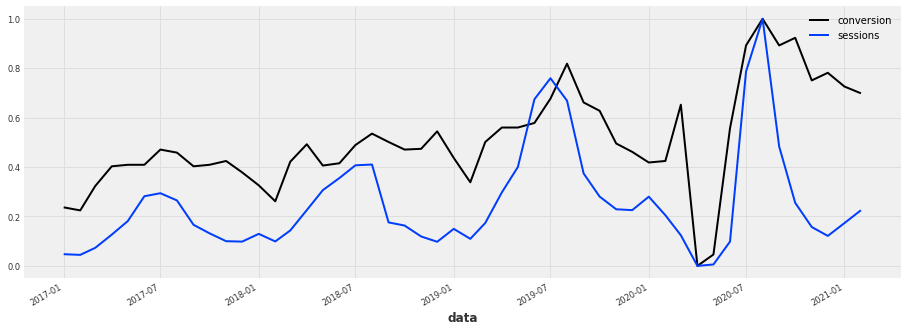

In [66]:
scaler_conv, scaler_ses = Scaler(), Scaler()
series_conv_scaled = scaler_conv.fit_transform(conversion)
series_ses_scaled = scaler_ses.fit_transform(sessions)
plt.figure(figsize=(14,5))
series_conv_scaled.plot(label='conversion')
series_ses_scaled.plot(label='sessions')
plt.legend();

Делю сериес на тренеровочные и тестовые данные

In [14]:
train_conv, val_conv = series_conv_scaled[:36], series_conv_scaled[36:48] 
train_ses, val_ses = series_ses_scaled[:36], series_ses_scaled[36:48]

Обучаю модель

In [64]:
model_ses_conv = NBEATSModel(input_chunk_length=12, output_chunk_length=12, n_epochs=100, random_state=0)
model_ses_conv.fit(train_conv, verbose=True)

[2022-02-18 17:42:47,601] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 13 samples.
[2022-02-18 17:42:47,601] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 13 samples.
[2022-02-18 17:42:47,652] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-18 17:42:47,652] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-18 17:42:47,653] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-18 17:42:47,653] WARNING | darts.models.forecasting.torch_forecasting_model | Deprecati

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s, loss=0.0018] 


In [61]:
model_ses_conv = NBEATSModel(input_chunk_length=12, output_chunk_length=12, n_epochs=150, random_state=0)
model_ses_conv.fit( [train_conv, train_ses], verbose=True)

[2022-02-18 17:42:05,904] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 26 samples.
[2022-02-18 17:42:05,904] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 26 samples.
[2022-02-18 17:42:05,966] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-18 17:42:05,966] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-18 17:42:05,967] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-18 17:42:05,967] WARNING | darts.models.forecasting.torch_forecasting_model | Deprecati

Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s, loss=0.000353]


Строю график по прогнозу

Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


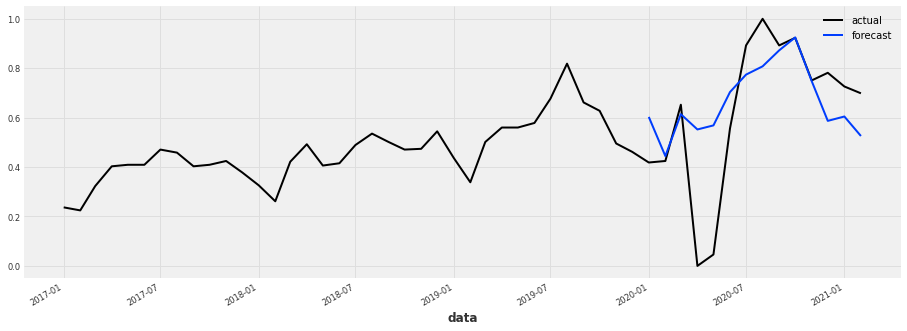

In [51]:
pred = model_ses_conv.predict(n=14, series=train_conv)
#ses_conv = scaler_conv.inverse_transform(pred).pd_series().reset_index().rename(columns={0:'conversion'})
plt.figure(figsize=(14,5))
series_conv_scaled.plot(label='actual')
pred.plot(label='forecast')

plt.legend();


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


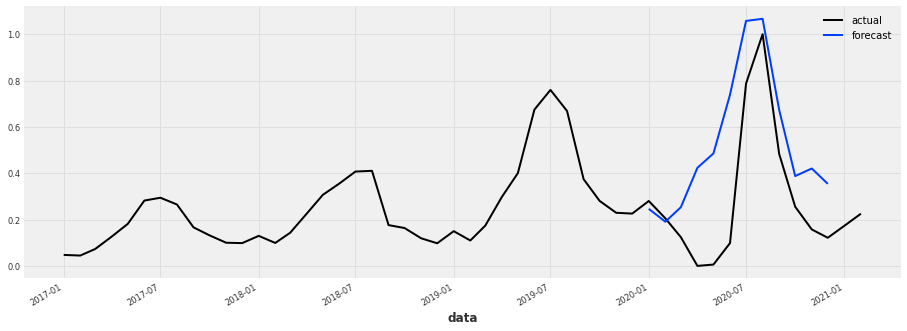

In [52]:
pred = model_ses_conv.predict(n=12, series=train_ses)
#ses_pred = scaler_ses.inverse_transform(pred).pd_series().reset_index().rename(columns={0:'sessions'})
plt.figure(figsize=(14,5))
series_ses_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();

Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


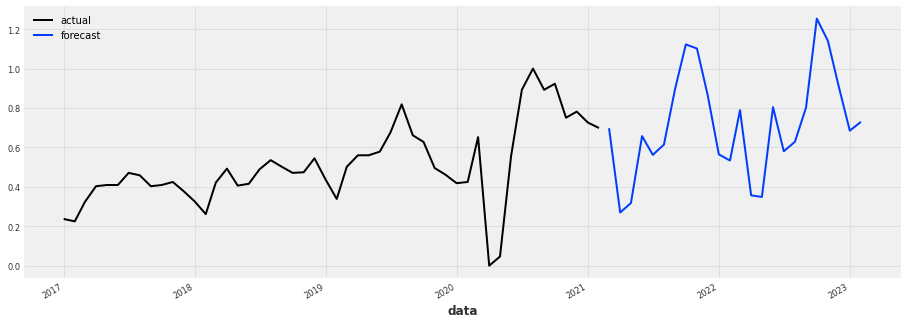

In [65]:
pred = model_ses_conv.predict(n=24, series=series_conv_scaled)
conv_pred = scaler_conv.inverse_transform(pred).pd_series().reset_index().rename(columns={0:'conversion'})
plt.figure(figsize=(14,5))
series_conv_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();


Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]


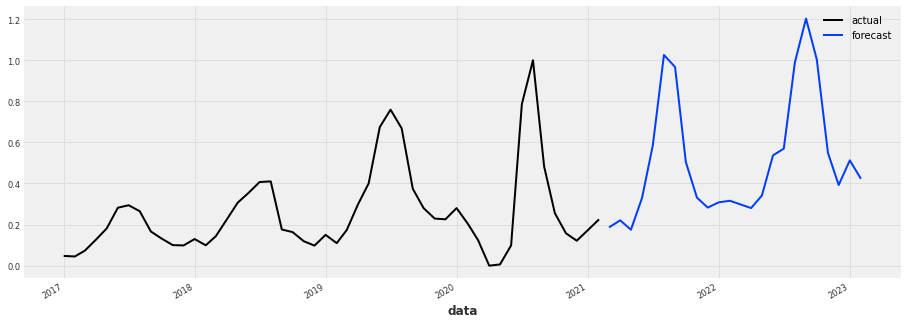

In [63]:
pred = model_ses_conv.predict(n=24, series=series_ses_scaled)
ses_pred = scaler_ses.inverse_transform(pred).pd_series().reset_index().rename(columns={0:'sessions'})
plt.figure(figsize=(14,5))
series_ses_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();

**Вывод:** я построил прогноз трафика и процента конверсии на март 2021-февраль 2023, думаю, что нейронная сеть не плохо справилась с улавливанием сезонности активности пользователей и с общим трендов увеличения количества сессий и конверсии. Не думаю, что нас ждут локдауны подобные апрелю-маю 2020 года, так что прогноз должен быть близким к реальности, было-бы интересно сравнить с уже имеющимися на данный момент данными. 


In [72]:
ses_pred.to_excel('сессии.xlsx')
conv_pred.to_excel('конверсия.xlsx')

In [71]:
df.to_excel('начальные данные.xlsx')